# Hands On XGBoost
### Hands On Notebook

m|rig GmbH

Gesa Murphy

## Aufgabe 1: Laden der Python-Bibliotheken

In [1]:
#pip install pandas numpy scikit-learn category_encoders xgboost matplotlib seaborn shap graphviz

In [2]:
# Standard Python Bibliotheken
import sys
import pandas as pd
import numpy as np

# Bibliotheken für Machine Learning und Data Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from category_encoders.woe import WOEEncoder #wird nur im optionalen Log Reg Teil verwendet.

# xgboost Biblothek
import xgboost as xgb

# Bibliotheken für Visualisierung
from plot_functions import plot_features # Eigene Plot-Funktion
import matplotlib.pyplot as plt
import graphviz
from xgboost import to_graphviz
import seaborn as sns


# Bibliothek für SHAP values (XAI)
import shap

# Setze Anzeigeoptionen für Pandas
pd.set_option('display.max_columns', None)



## Aufgabe 2: Lade und analysiere den Datensatz "Taiwanese Credit Card Default Data"
Importiere die csv "default of credit card clients preprocessed.csv" als Data.Frame.

In [3]:
# Lade csv als Data.Frame
df = pd.read_csv("default of credit card clients preprocessed v3.csv", sep=";")

# Die Merkmale des Datensatzes werden in ID (primary key), metrische und kategoriale erklärende Merkmale sowie die Zielvariable (abhängige Variable) unterteilt.
id_col = 'ID'
met_features = [col for col in df.drop(['ID', 'default'], axis=1).select_dtypes(include=['int32', 'int64', 'float32', 'float64']).columns.tolist() ]
cat_features = df.select_dtypes(include=['object', 'category']).columns.tolist() 
target_col = 'default'


### Merkmalserläuterungen
- ID: primary key
- LIMIT_BAL: Kreditlimit 
- Sex: Geschlecht
- EDUCATION: höchster Bildungsabschluss
- MARRIAGE: Familienstand
- AGE: Alter in Jahren
- payment_status_mx: Verzugsstatus im x. Monat vor Ausfall
    - -1: Rechtzeitig alles bezahlt ('paid on time')
    - 0: Nur das nötigste gezahlt ('use of revolving credit')
    - 1-8: Anzahl Monate in Überziehung
    
- bill_amount_mx: Offener Betrag im x. Monat vor Ausfall
- payment_amount_mx: Bezahlter Betrag im x. Monat vor Ausfall
- default: Zielvariable (1 - Ausfall, 0 - kein Ausfall)


Aufgabe: 

Analysiere den Datensatz näher:
- Verwende die head-Methoden des DateFrames df
- Verwende die describe-Methode des DateFrames df auf den kategorialen Merkmalen verwende .astype("object") um alle kategorialen Features als solche zu betrachten.
- Verwende die describe-Methode des DateFrames df auf den numerischen Merkmalen inkl. percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]


In [4]:
# Gibt die ersten 5 Zeilen des DataFrames aus
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,payment_status_m1,payment_status_m2,payment_status_m3,payment_status_m4,payment_status_m5,payment_status_m6,bill_amount_m1,bill_amount_m2,bill_amount_m3,bill_amount_m4,bill_amount_m5,bill_amount_m6,payment_amount_m1,payment_amount_m2,payment_amount_m3,payment_amount_m4,payment_amount_m5,payment_amount_m6,default
0,1,20000,female,university,married,24,2.0,2.0,-1.0,-1.0,NaN,NaN,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,female,university,single,26,-1.0,2.0,0.0,0.0,0.0,2.0,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,female,university,single,34,0.0,0.0,0.0,0.0,0.0,0.0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,female,university,married,37,0.0,0.0,0.0,0.0,0.0,0.0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,male,university,married,57,-1.0,0.0,-1.0,0.0,0.0,0.0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
# Verteilung der kategorialen Merkmale
df[cat_features].describe(include='all')

,SEX,EDUCATION,MARRIAGE
count,30000,29986,29946
unique,2,4,3
top,female,university,single
freq,18112,14030,15964


In [6]:
# Verteilung der metrischen Merkmale
df[met_features].describe(include='all', percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])

,LIMIT_BAL,AGE,payment_status_m1,payment_status_m2,payment_status_m3,payment_status_m4,payment_status_m5,payment_status_m6,bill_amount_m1,bill_amount_m2,bill_amount_m3,bill_amount_m4,bill_amount_m5,bill_amount_m6,payment_amount_m1,payment_amount_m2,payment_amount_m3,payment_amount_m4,payment_amount_m5,payment_amount_m6
count,30000.000000,30000.000000,27241.000000,26218.000000,25915.000000,25652.000000,25454.000000,25105.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,167484.322667,35.485500,0.184171,0.135441,0.122863,0.080929,0.043451,0.042103,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,129747.661567,9.217904,0.975753,1.032043,1.022076,0.985371,0.938445,0.948618,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,10000.000000,21.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
5%,20000.000000,23.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,50000.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,140000.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,240000.000000,41.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
95%,430000.000000,53.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,201203.050000,194792.200000,1.878210e+05,174333.350000,165794.300000,161912.000000,18428.200000,1.900435e+04,17589.40000,16014.950000,16000.000000,17343.800000
max,1000000.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


Aufgabe: Erzeuge Grafiken zur Verteilung der einzelnen Merkmale.

Nutze hierzu die in plot_functions.py vordefinierten Funktion "plot_features".

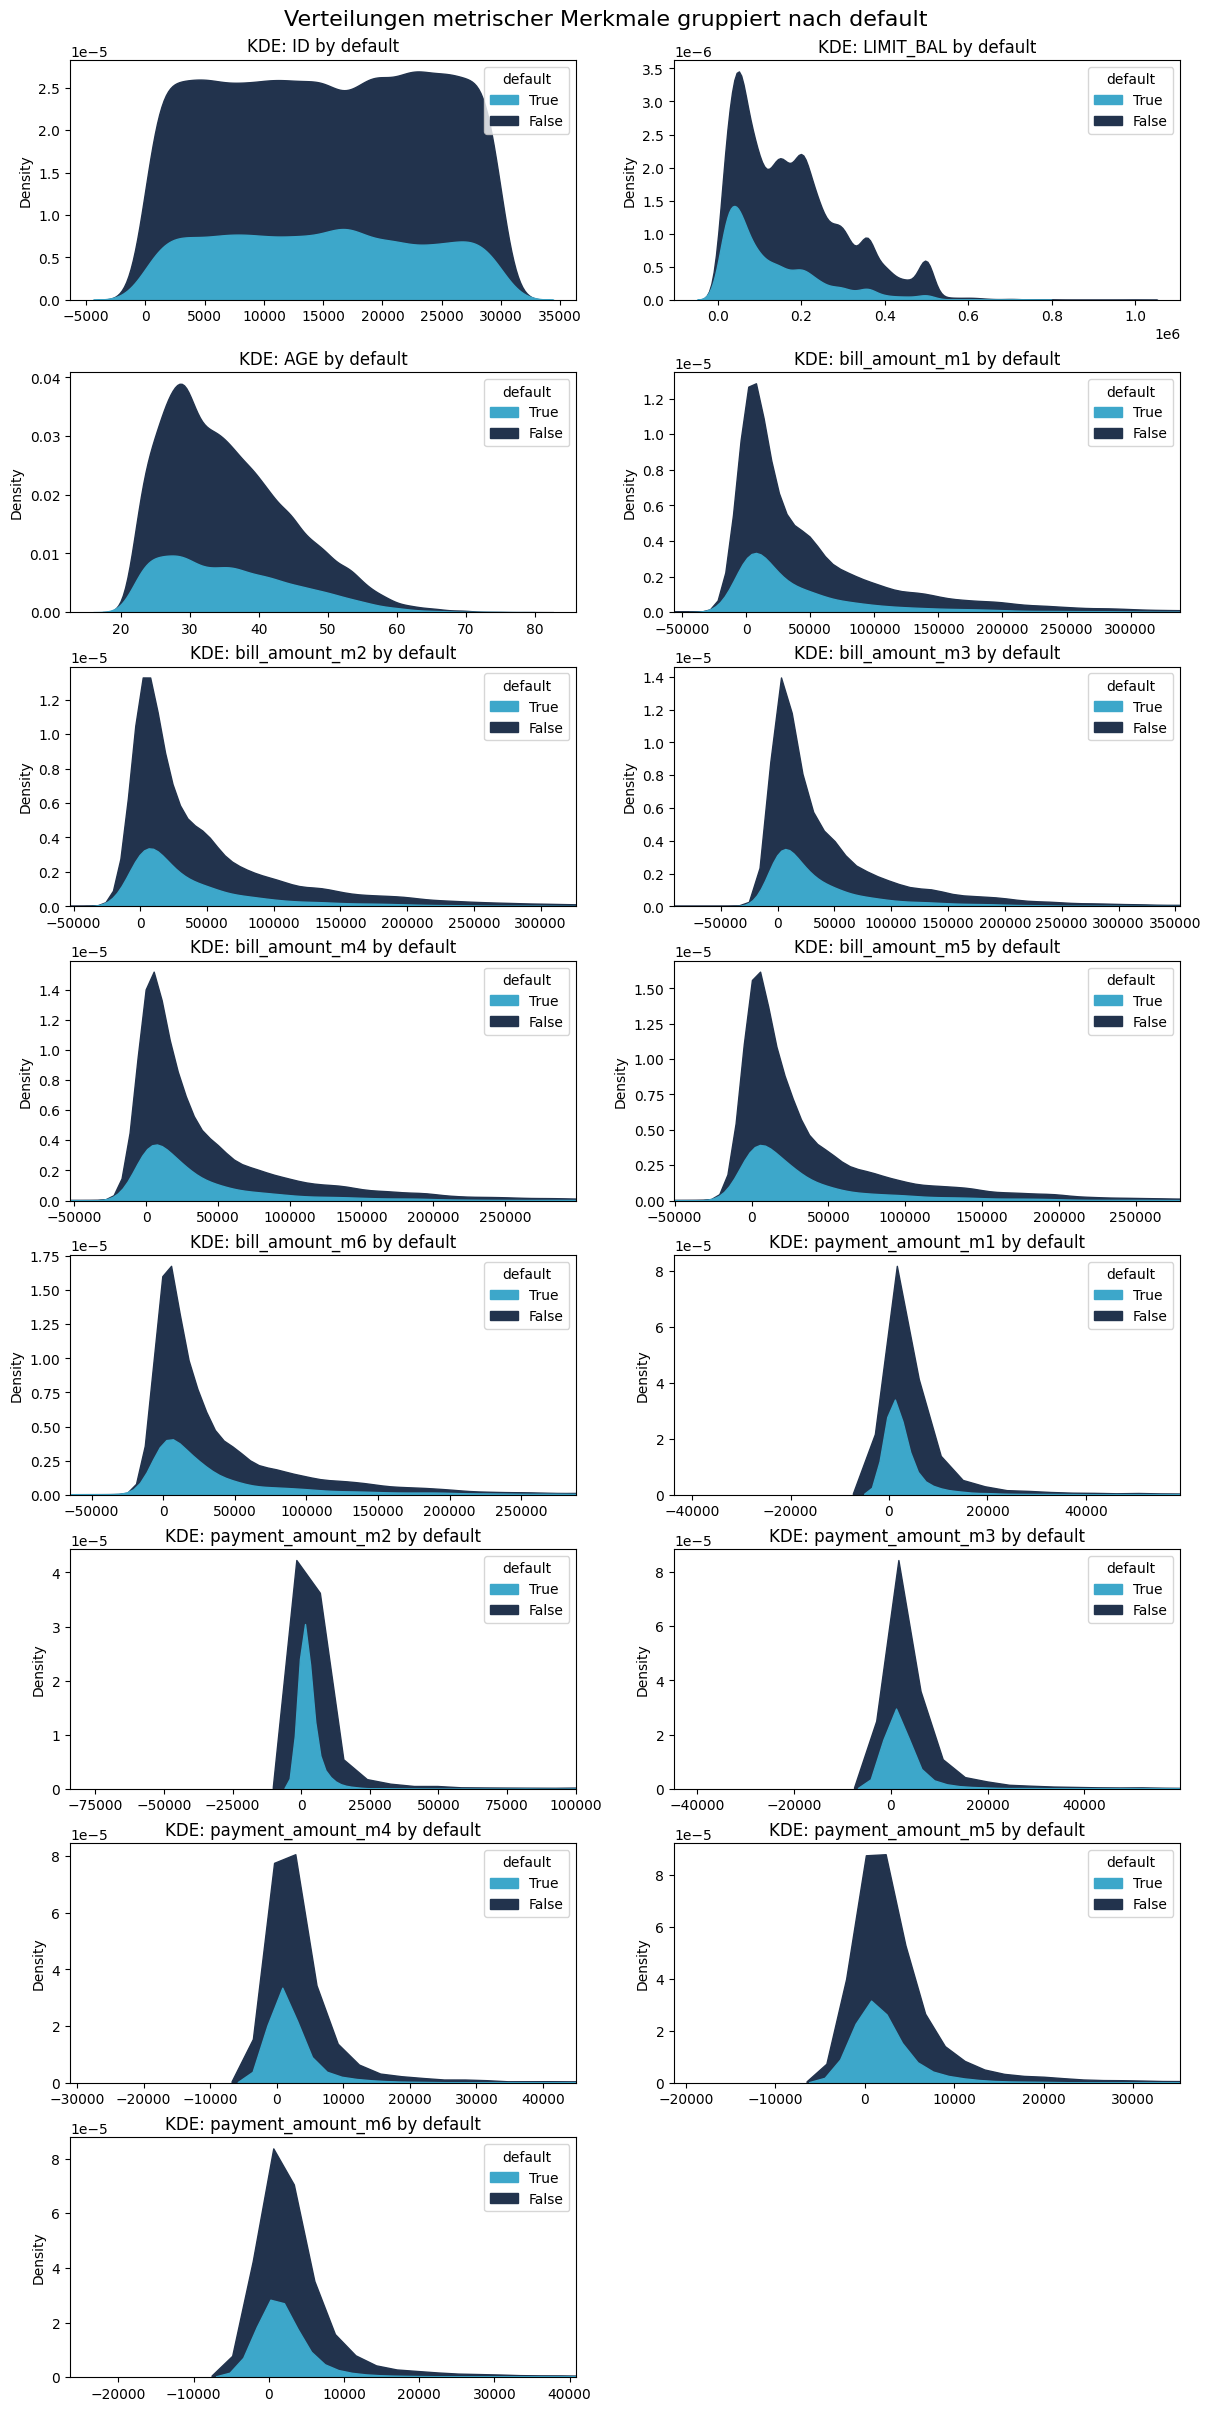

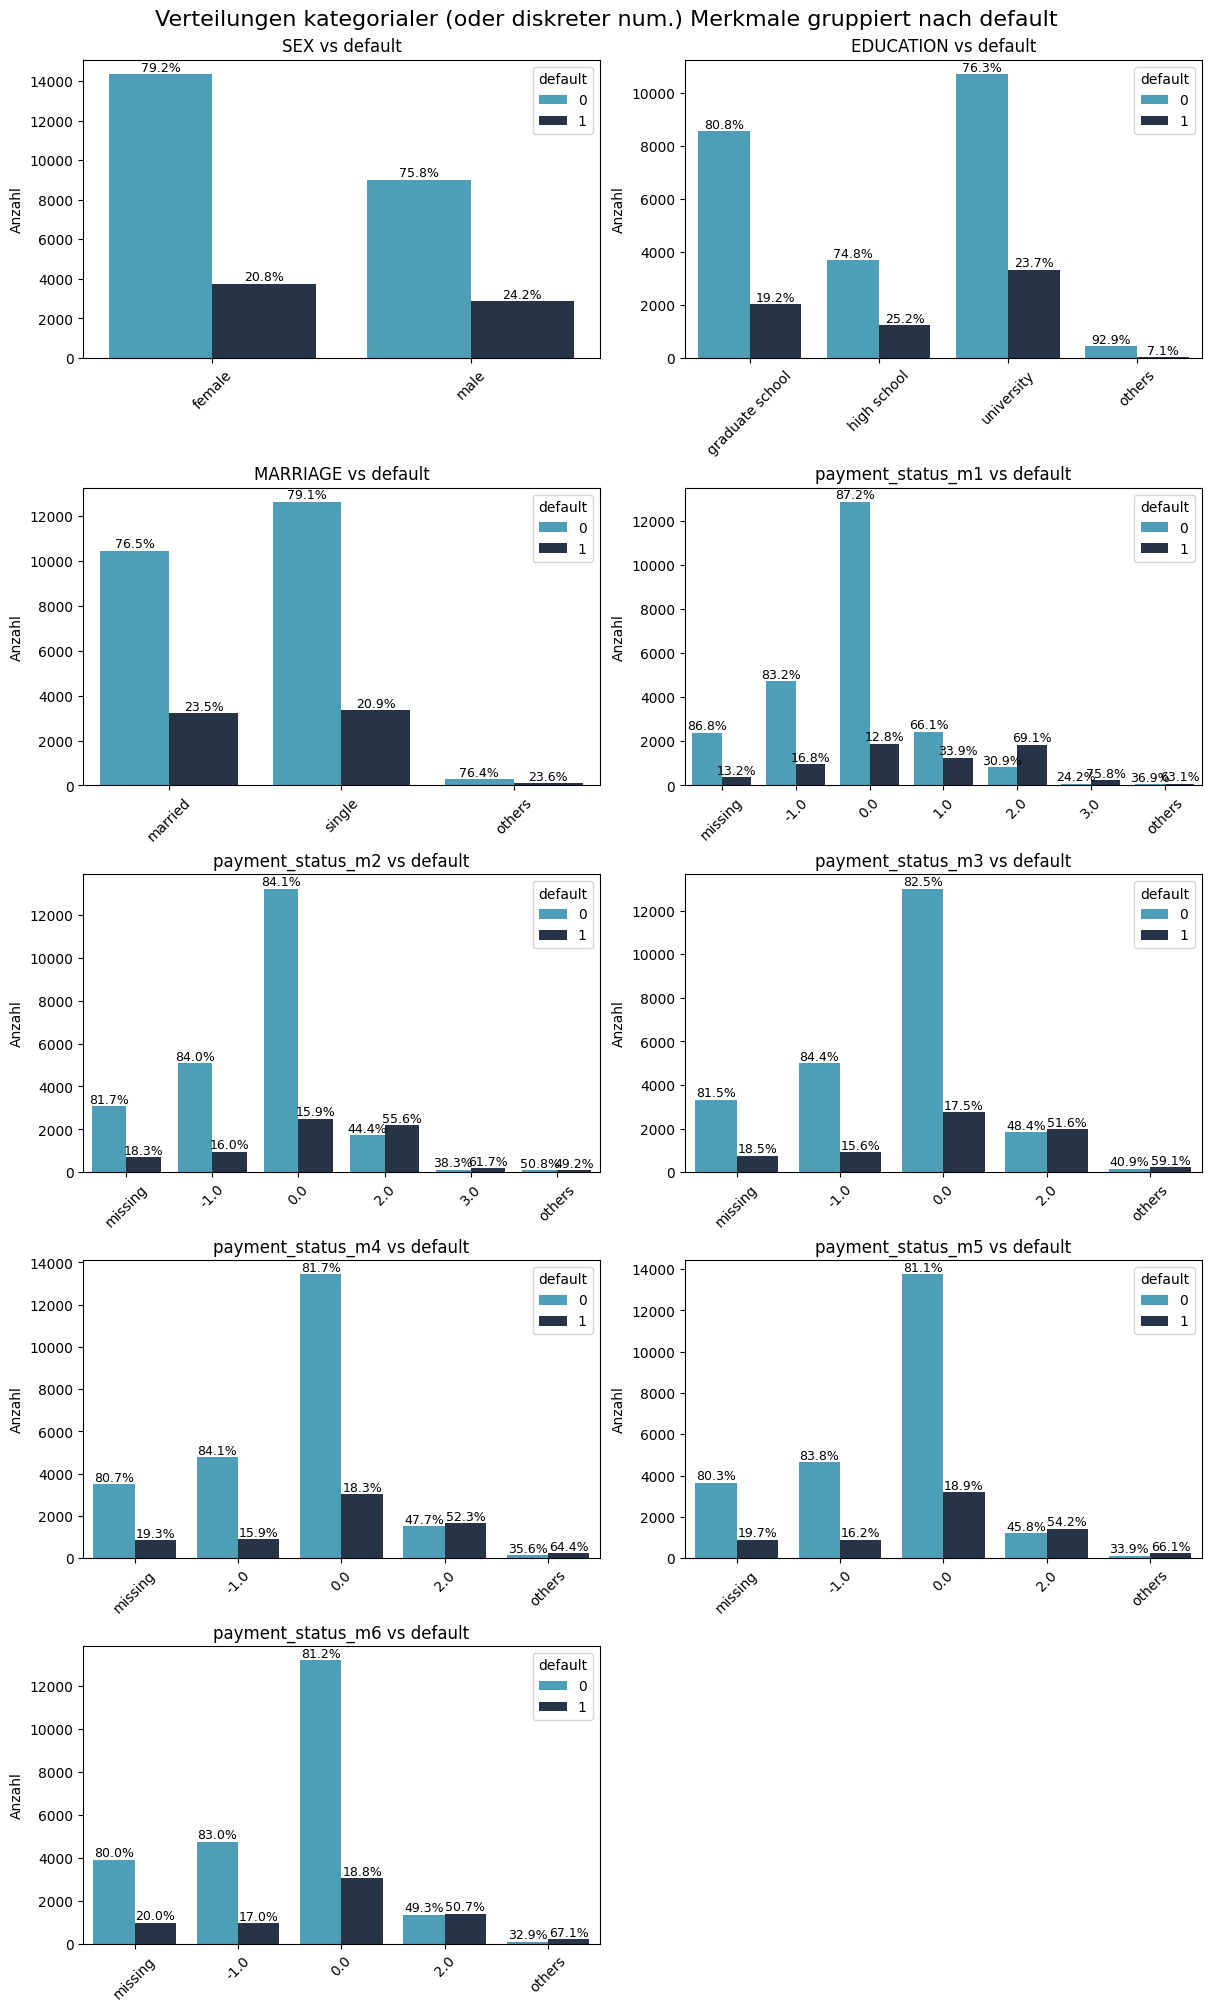

In [7]:
plot_features(df,target_col)

Achtung Korrelation: Sind viele Features miteinander korreliert, hat die logistische Regression manchmal Problem. (Zum Glück gibt es XGBoost)

<Axes: >

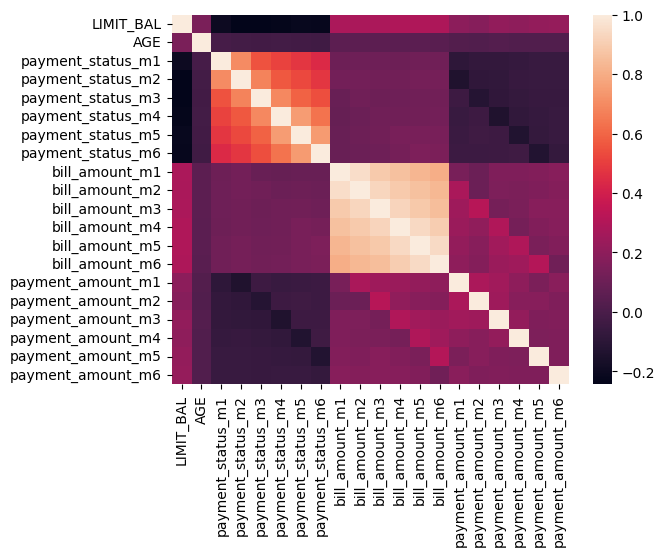

In [8]:
sns.heatmap(df[met_features].corr(method='pearson'))

Fragen Aufgabe 2:
- Zu welchen Merkmalen liegen Missings vor?
- Welche Merkmale sehen schon besonders trennscharf aus?
- Gehören die Missings eher zu den positiven oder negativen Merkmalen (Was ist ihre Ausfallrate im Vergleich zu den anderen Ausprägungen?)
- Welche Merkmale sind miteinander korreliert?

Antworten Aufgabe 2:
- EDUCATION, MARRIAGE und payment_status_MMM
- Die payment_status features haben sehr eindeutig unterschiedliche Ausfallraten je Ergebnis.
- Die Missings haben eine eher niedrigere Ausfallrate.
- Die bill_amount features sind sehr hoch korreliert. Die Payment Status features sind auch korreliert.

## Aufgabe 3: XGBoost
Trainiere ein xgboost-Modell. Speichere hierzu die erklärenden Variablen unter X_xgb und die Zielvariablen unter y ab.
Es gibt mind. zwei Möglichkeiten mit Objektvariablen umzugehen:
- Variante 1: kategorische Variablen mit OneHot-Encoding transformieren
- Variante 2: kategorische Variablen direkt verwenden

### 3.1 Variante 1: kategorische Variablen mit OneHot-Encoding transformieren

In [9]:
# OneHot-Encoding der kategorialen Variablen inklusive Dummy-Variable für fehlende Werte
X_xgb_mD = pd.get_dummies(df.drop([id_col, target_col], axis = 1), columns=cat_features, dummy_na=True, drop_first=True, dtype=np.int8, prefix=cat_features).copy()
y_xgb_mD =  df[target_col]

In [10]:
# Train-Test-Split
X_train_xgb_mD, X_test_xgb_mD, y_train_xgb_mD, y_test_xgb_mD = train_test_split(
    X_xgb_mD, y_xgb_mD, test_size=0.2, random_state=42
)

In [11]:
# Modelldesign und Training
xgb_model_mD = xgb.XGBClassifier(
    max_depth=4,
    objective='binary:logistic',
    n_estimators=500,
    eval_metric='logloss'
)
xgb_model_mD.fit(X_train_xgb_mD, y_train_xgb_mD)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [12]:
# Modellevaluation
y_probs_mD = xgb_model_mD.predict_proba(X_test_xgb_mD)[:, 1]

gini = 2 * roc_auc_score(y_test_xgb_mD, y_probs_mD) - 1
print(f"Gini: {gini:.4f}")

Gini: 0.5256


### 3.2 Variante 2: kategorische Variablen direkt verwenden

In [13]:
# Ersetze object column type mit category
X_xgb = pd.concat([df[met_features], df[cat_features].astype('category')], axis=1)
y_xgb =  df[target_col]

In [14]:
# Train-Test-Split
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X_xgb, y_xgb, test_size=0.2, random_state=42
)

In [15]:
# Modelldesign und Training
xgb_model = xgb.XGBClassifier(
    max_depth=4,
    objective='binary:logistic',
    n_estimators=500,
    eval_metric='logloss',
    enable_categorical=True # Handeln von kategorischen Variablen - nicht nötig, wenn sie in Dummies umgewandelt werden.
)
xgb_model.fit(X_train_xgb, y_train_xgb)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,'logloss'


In [16]:
# Modellevaluation
y_probs = xgb_model.predict_proba(X_test_xgb)[:, 1]

gini = 2 * roc_auc_score(y_test_xgb, y_probs) - 1
print(f"Gini: {gini:.4f}")

Gini: 0.5284


Frage Aufgabe 3.1 / 3.2:
- Was sind mögliche Vor- und Nachteile der beiden Varianten?

Antwort Aufgabe 3.1 / 3.2:

Vorteile der zweiten Variante (enable_categorical=True - native kategorische Features in XGBoost):

- Reduzierter manueller Aufwand: Keine manuelle Bestimmung von Dummy-Variablen, da XGBoost category-Spalten direkt erkennt und verarbeitet.
- Effizientere Verarbeitung: Native Behandlung ist oft schneller und speicherschonender als One-Hot-Encoding, besonders bei vielen Kategorien, da bei vielen Kategorien viele neue Features erzeugt werden müssen.
- Bessere Modellgüte: XGBoost kann optimale Splits für Kategorien finden, was manchmal zu besserer Performance führt als einfaches Label- oder One-Hot-Encoding.

Nachteile:
- Datenaufbereitung: Die Spalten müssen explizit als category-Typ vorliegen oder klassifiziert werden.
- Manche Pipelines oder Export-Formate erwarten numerische Features. Es kann daher zu komplikationen mit anderen Codebestandteilen kommen.
- Weniger Kontrolle: Bei One-Hot-Encoding kannst du gezielt seltene Kategorien zusammenfassen oder Dummy-Variablen für Missings erzeugen.

### 3.3 Xgboost-Modell verstehen


Aufgabe: Visualisiere den ersten Baum sowie die Bäume 10 / 50 /100 mit "to_graphviz".

Tipp: Verwende "size" um die Größe der Grafik anzupassen und rankdir='LR' um die Ausrichtung zu ändern.

Erklärung der Darstellung: Die Darstellung von Bäumen mit to_graphviz und plot_tree von XGB ist meiner Meinung nach noch nicht ideal und etwas verwirrend. Abzweigungen mit kategorischen Merkmalen zeigen zusätzlich zur enthaltenen Menge noch einen Wert für gain und cover an. Metrische Merkmale nicht.

Hinweis: Die Leaf Values sind Log Odds. Wendet man auf sie die Sigmoid Funktion an, erhält man Wahrscheinlichkeiten zwischen 0 und 1. Leaf Werte kleiner als 0 führen zu Wahrscheinlichkeiten unter 50%. Je höher der Leaf Value, für desto wahrscheinlicher wird ein Ausfall gehalten.

c:\Users\GesaMurphy\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


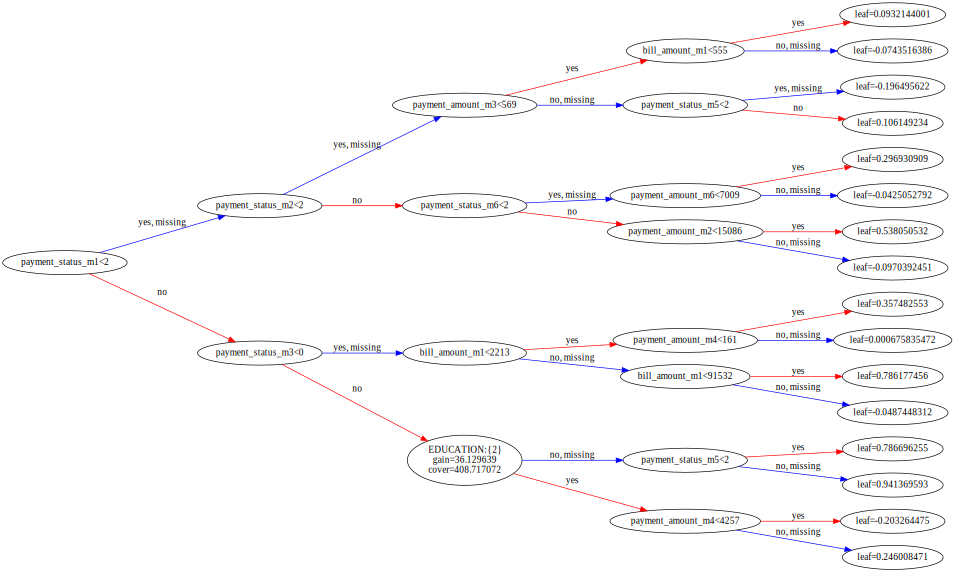

In [17]:
# Darstellung des ersten Baumes
to_graphviz(xgb_model, num_trees=0, rankdir='LR', size = '15,8')

Aufgabe: Visualisiere die Feature Importance nach "gain". Du kannst auch die Importance mit "cover" oder "weight" betrachten.

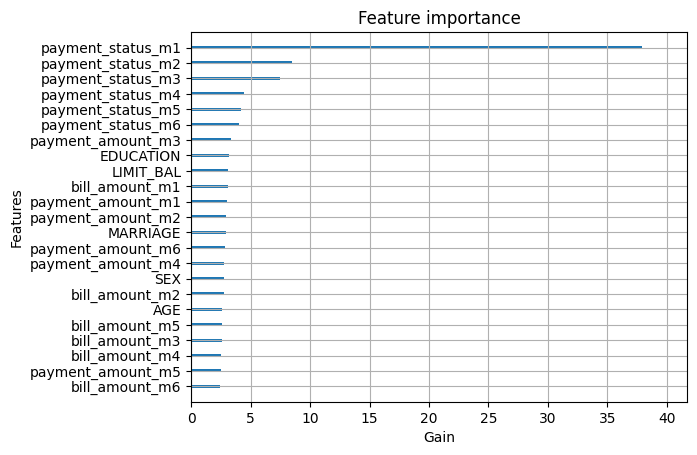

In [18]:
xgb.plot_importance(xgb_model, importance_type='gain', xlabel='Gain', show_values=False)
plt.show()

Aufgabe 3.3:
- Welche Auffälligkeiten gibt es beim Vergleich der Bäume mit unterschiedlichen Iterationsnummern?
- Plausiblisiere die Feature Importance fachlich.

Antwort 3.3:
- Die Absolutwerte in den Leafs nehmen tendenziell ab.
- Aktuellere Features haben einen höheren Impact auf das Modell. Payment_status ist eng mit dem Ausfallkriterium verbunden und hat daher einen höheren Einfluss.

### 3.4 xgboost-Modell optimieren

Baumstruktur:


| Parameter           | Beschreibung                                                   | Typischer Bereich | Default |
|---------------------|------------------------------------------------------------------|-------------------|---------|
| `n_estimators`      | Anzahl der Bäume (Boosting-Runden)                              | 50 – 1000         | `100`   |
| `max_depth`         | Maximale Tiefe der Bäume                                        | 2 – 15            | `6`     |
| `min_child_weight`  | Minimale Summe der Gewichte pro Blattknoten                    | 1 – 10            | `1`     |
| `subsample`         | Anteil der Trainingsdaten, die pro Baum verwendet werden       | 0.5 – 1           | `1.0`   |
| `colsample_bytree`  | Anteil der Merkmale, die pro Baum verwendet werden             | 0.3 – 1           | `1.0`   |
| `colsample_bylevel` | Anteil der Merkmale pro Level (Tiefe)                          | 0.3 – 1           | `1.0`   |
| `colsample_bynode`  | Anteil der Merkmale pro Knoten                                 | 0.3 – 1           | `1.0`   |
| `scale_pos_weight`  | Gewichtung der positiven Klasse (bei Ungleichgewicht)          | 1 – 100 (je nach Unbalance) | `1.0` |

Lernrate und Regularisierung:

| Parameter       | Beschreibung                                               | Typischer Bereich | Default |
|-----------------|------------------------------------------------------------|-------------------|---------|
| `learning_rate` | Lernrate / Schrittweite des Boostings                      | 0.01 – 0.3        | `0.3`   |
| `gamma`         | Mindestverlustreduktion für einen Split (`min_split_loss`) | 0 – 10            | `0.0`   |
| `reg_alpha`     | L1-Regularisierung (Lasso) auf Blattwerte                  | 0 – 10            | `0.0`   |
| `reg_lambda`    | L2-Regularisierung (Ridge) auf Blattwerte                  | 0 – 10            | `1.0`   |

Es folgt Code für ein einfaches Gridsearch. Mit den vorgeschlagenen Parametern dauert es etwa 1 Minute. Versuche den Code anzupassen (passe dazu das param_grid an) und auf ein noch besseres Ergebnis zu kommen.

Aber je mehr Parameter oder Werte du mit reinnimmst, desto länger läuft der Code!

In [19]:
# Basis-Modell für Grid Search
xgb_model_GS = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    enable_categorical=True 
)

# Parameter-Grid definieren
param_grid = {
    'n_estimators': [250], # [100, 250, 500]
    'max_depth': [ 2, 3], #[3,4, 5,6 7],
    'gamma': [1, 2], #  [0, 1, 2, 3, 4, 5],
    'colsample_bytree': [0.8, 1.0], # [0.8],
    'learning_rate': [0.1, 0.1], # [0.01, 0.05, 0.1],
    'reg_alpha': [2, 3], # [0, 1, 2, 3, 4, 5],
    'reg_lambda': [1, 2] #[0, 3, 5] 
}

# Grid Search konfigurieren
grid_search = GridSearchCV(
    estimator=xgb_model_GS,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=3, # Cross-Validation mit 3 Folds
    verbose=2, # detaillierter Output
    n_jobs=-1 # alle verfügbaren Kerne nutzen 
)

# Training 100 fits < 1 min
grid_search.fit(X_train_xgb, y_train_xgb)

# Beste Parameter & Genauigkeit
print("Beste Parameter:", grid_search.best_params_)
print("Beste CrossValidation-Genauigkeit:", grid_search.best_score_)

# Test-Performance
best_model = grid_search.best_estimator_
y_probs = best_model.predict_proba(X_test_xgb)[:, 1]

gini = 2 * roc_auc_score(y_test_xgb, y_probs) - 1
print(f"Gini: {gini:.4f}")

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Beste Parameter: {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 250, 'reg_alpha': 3, 'reg_lambda': 1}
Beste CrossValidation-Genauigkeit: 0.7809445476837359
Gini: 0.5668


Schau dir das best_model einmal an:

In [20]:
best_model

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,'logloss'


## Aufgabe 4: Erklärbarkeit des Modells mit Shapley values.

### XGBoost

Verwende das best_model. Es sollte vermutlich kategorische Merkmale verwendet haben.

In [21]:
# SHAP Werte berechnen
explainer_xgb = shap.Explainer(best_model)
shap_values_xgb = explainer_xgb(X_test_xgb)

Betrachte die Feature Importance mit SHAP. Vergleiche mit der feature_importance die direkt von XGBoost kam.

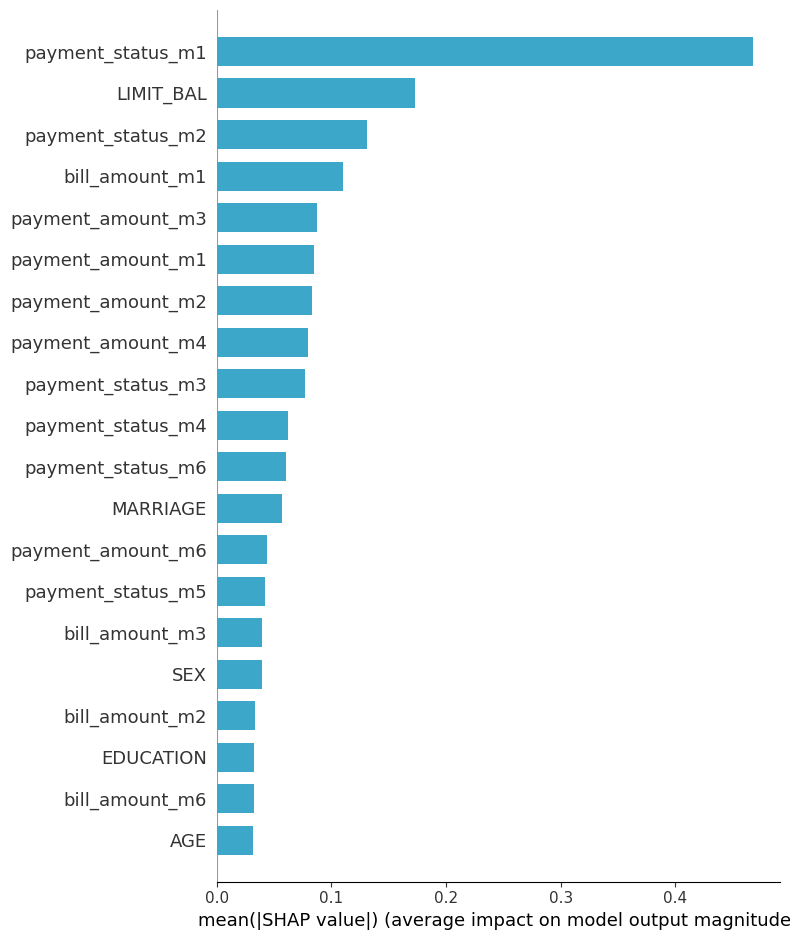

In [22]:

shap.summary_plot(shap_values_xgb,plot_type='bar')

Betrachte den Einfluss der SHAP Value nach Feature Werten (summary plot ohne plot_type)

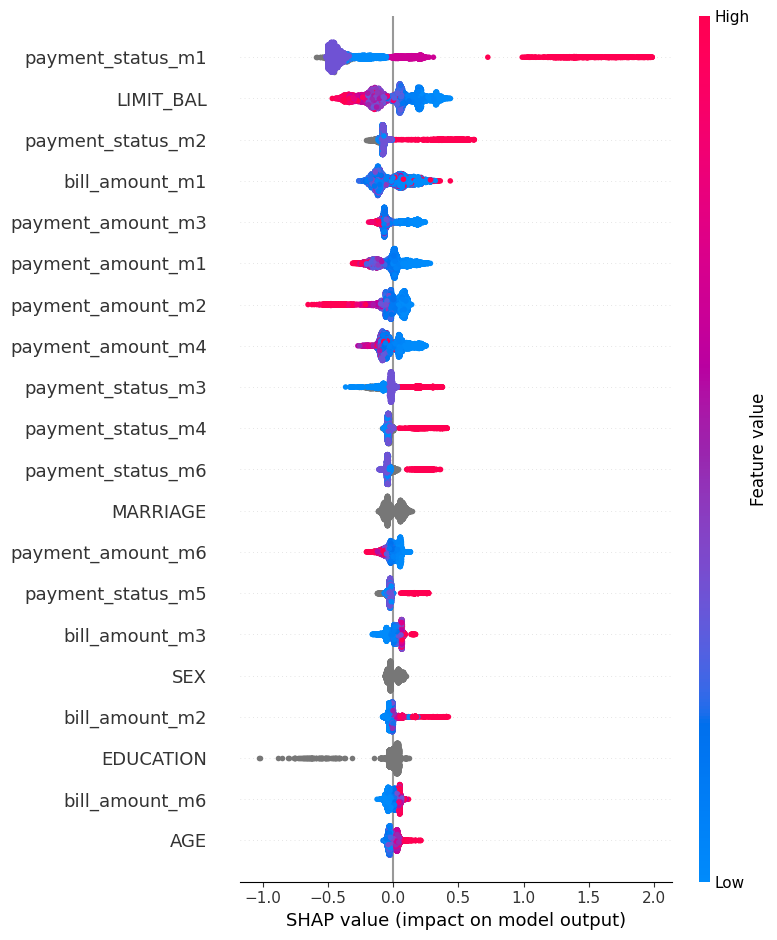

In [23]:
shap.summary_plot(shap_values_xgb)

Dieser wird auch beeswarm Plot genannt und kann so aufgerufen werden (mit abgekürzter Graphik):

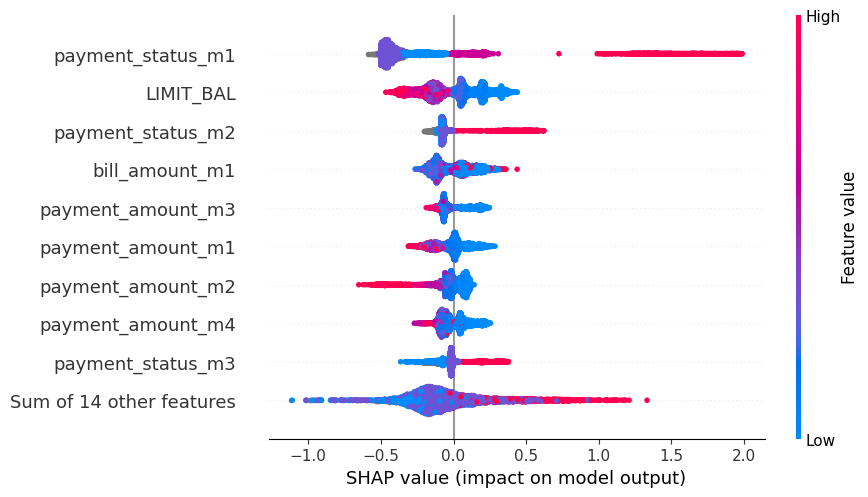

In [24]:
shap.plots.beeswarm(shap_values_xgb)

Vergleiche den Beeswarm Plot des best_model mit dem einfachen Model mit dummies:

Das beste Modell sollte viel definierter sein in der Verteilung der Shap Values auf die Feature Values.

In [25]:
explainer_xgb_mD = shap.Explainer(xgb_model_mD)
shap_values_xgb_mD = explainer_xgb_mD(X_test_xgb_mD)

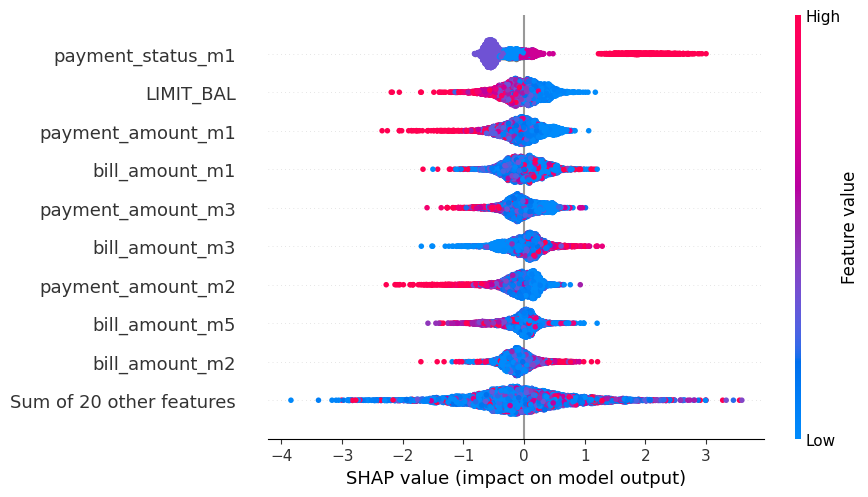

In [26]:
shap.plots.beeswarm(shap_values_xgb_mD)

Betrachte die Verteilung der Shap Values bei einem einzelnen Feature, dem mit der größten Feature Importance: (zurück zum Best Model):

c:\Users\GesaMurphy\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\plots\_scatter.py:452: RuntimeWarning: invalid value encountered in greater
  min_dist = np.min(diffs[diffs > 1e-8])


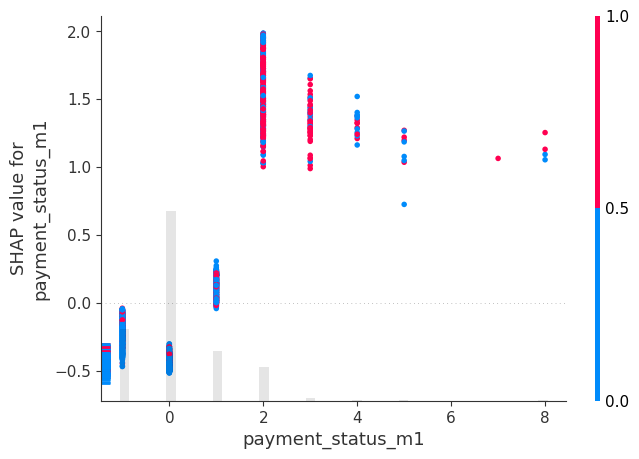

In [27]:

shap.plots.scatter(shap_values_xgb[:, 'payment_status_m1'],color =y_test_xgb.to_numpy())


An diesem Plot kann man schön sehen, dass auch bei gleichbleibendem Feature Wert (z.B. payment_status_m1==1) verschiedene SHAP Values möglich sind.

## Aufgabe 5: Optional: Logistische Regression

Dieser Teil des Notebooks ist optional. Wir haben allen Code hier drin gelassen, da wir mit diesem Teil nur aufzeigen wollen, was bei logisitischer Regression, die in Banken üblicherweise für die Schätzung eines PD Modells genutzt wird, alles extra getan werden muss. Im Gegensatz zu XGBoost können wir die Daten nicht einfach in ein einfaches XGB Modell reinnehmen, sondern müssen mit Missings und anderen Problemen vorher umgehen:


### 5.1 Einfaches Logistisches Regressionsmodell
Baue zunächst ein logistisches Regressionsmodell mit einem Minimum an Datenvorbereitung (alle kategorischen Feature in dummy Variablen umwandeln).

In [28]:
# OneHot-Encoding der kategorialen Variablen inklusive Dummy-Variable für fehlende Werte
X_lr_simple = pd.get_dummies(df.drop([id_col, target_col], axis = 1), columns=cat_features, drop_first=True, prefix=cat_features).copy()
y_lr_simple =  df[target_col]

In [29]:

# Train-Test-Split
X_slr_train, X_slr_test, y_slr_train, y_slr_test = train_test_split(
    X_lr_simple,y_lr_simple, test_size=0.2, random_state=42
)

In [30]:
# Modelldesign und Training
lr = LogisticRegression(max_iter=1000)
lr.fit(X_slr_train, y_slr_train)

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

Dieser Fehler kommt, weil na enthalten sind. Also: ganz so einfach geht es nicht. Wir können die nas ersetzen, z.B. durch den Median oder Mean:

In [31]:
for feature in met_features:
    X_lr_simple[feature] = X_lr_simple[feature].fillna(X_lr_simple[feature].mean())

Wiederhole Train test split und Log Reg

In [32]:
# Train-Test-Split
X_slr_train, X_slr_test, y_slr_train, y_slr_test = train_test_split(
    X_lr_simple,y_lr_simple, test_size=0.2, random_state=42
)

In [33]:
# Modelldesign und Training
lr = LogisticRegression()
lr.fit(X_slr_train, y_slr_train)

c:\Users\GesaMurphy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


Diesmal sollte eine Warnung gekommen sein, dass das Modell nicht konvergiert ist. (viele korrelierende Variablen). Man bekommt trotzdem eine Prediction (siehe nächstes Codefeld), aber eben nicht die beste.
Es gibt viele Lösungen, z.B. 
- max_iter hochsetzen
- korrelierende Variablen rausschmeißen (z.B. nur 1. Monat vor Ausfall benutzen (payment_status_m1, bill_amount_m1,..)
- Alle features skalieren mit
X_scaled = scaler.fit_transform(X_lr_simple)
X_slr_train, X_slr_test, y_slr_train, y_slr_test = train_test_split(
    X_scaled,y_lr_simple, test_size=0.2, random_state=42
)

Oder aber, wie in 5.2, mehr Datenaufbereitung betreiben und alle Merkmale gruppieren.

In [34]:
# Modellevaluation
y_probs = lr.predict_proba(X_slr_test)[:, 1]

gini = 2 * roc_auc_score(y_slr_test, y_probs) - 1
print(f"Gini: {gini:.4f}")

Gini: 0.3125


### 5.2 Logistisches Regressionsmodell mit Datenaufbereitung
Baue ein logistisches Regressionsmodell mit einer ausführlicheren Datenaufbereitung. Dies entspricht sicher noch lange nicht einer vollständigen PD Modellierung, aber die Ergebnisse kommen dem schon näher.

Die Features werden alle gruppiert um dann später mit einem WOE Encoder einen bestimmten neuen Wert zu erhalten, der dann als Feature eingeht statt den Originalfeatures.
Die Behandlung von Missings wird mit .fillna(Wert_den_missing_erhalten_sollen) geregelt, also Missings werden nicht ausgeschlossen, sondern (zunächst) durch passende Kategorien (others) oder Mittlere Werte (bei good/bad/very bad ist bad der mittlere Wert). Falls ihr an dieser Stelle noch etwas Zeit habt, könnt ihr ja mal probieren, wieviel besser oder schlechter das Modell wird, wenn man die .fillna der payment status features auf good oder very bad setzt.

In [35]:
df_lr = df.copy()

# Gruppiere Merkmale

# SEX, EDUCATION, MARRIAGE
df_lr['grp_SEX'] = df_lr['SEX'] # in einem richtigen PD Modell würde normalerweise das Geschlecht nicht eingehen.

df_lr['grp_EDUCATION'] = df_lr['EDUCATION'].replace({
    'graduate school': 'higher',
    'university': 'higher',
    'high school': 'medium and others',
    'others': 'medium and others'
}).fillna('medium and others') # fehlende Werte werden der Gruppe 'medium and others' zugeordnet

df_lr['grp_MARRIAGE'] = df_lr['MARRIAGE'].replace({
    'married': 'married',
    'single': 'single and others',
    'others': 'single and others'
}).fillna('single and others') # fehlende Werte werden der Gruppe 'single and others' zugeordnet

# Gruppiere numerische Merkmale
df_lr['grp_AGE'] = pd.cut(df_lr['AGE'], bins=[0, 25, 40, 50, 60, np.inf])

df_lr['grp_LIMIT_BAL'] = pd.cut(df_lr['LIMIT_BAL'], bins=[0, 25000, 50000, 100000, 150000, 300000, np.inf])

for feature in df_lr.columns:
    if feature.startswith('bill_amount'):
        df_lr['grp_' + feature] = pd.cut(df_lr[feature], bins=[-np.inf, 50000, np.inf])
    if feature.startswith('payment_amount'):
        df_lr['grp_' + feature] = pd.cut(df_lr[feature], bins=[0, 1000, 3000, 5000, 10000, np.inf])
    if feature.startswith('payment_status'): # Fokus auf payment_status Merkmale
        df_lr['grp_' + feature] = df_lr[feature].replace({
            -1: 'good',
            0: 'good',
            1: 'bad',
            2: 'very bad',
            3: 'very bad',
            4: 'very bad',
            5: 'very bad',
            6: 'very bad',
            7: 'very bad',
            8: 'very bad'
        }).fillna('bad')        # fehlende Werte der mittleren Kategorie zuordnen

# Reduziere Spalten auf gruppierte Merkmale
df_lr_grp = df_lr.loc[:, df_lr.columns.str.startswith('grp_')]


In [36]:
# Train-Test-Split
X_lr_train, X_lr_test, y_lr_train, y_lr_test = train_test_split(
        df_lr_grp, df_lr[target_col], test_size=0.2, random_state=42
)

In [37]:
# Modelldesign und Training
# Das Logistische Regressionsmodell wird in einer Pipeline zusammen mit dem WOE-Encoder trainiert.
pipeline = Pipeline(steps=[
    ("woe", WOEEncoder(
        cols=df_lr_grp.columns.tolist(),
        handle_missing="value",
        handle_unknown="value",
        randomized=False
    )),
    ("logit", LogisticRegression(max_iter=1000))
])

pipeline.fit(X_lr_train, y_lr_train)

,steps,"[('woe', ...), ('logit', ...)]"
,transform_input,None
,memory,None
,verbose,False
,verbose,0
,cols,"['grp_SEX', 'grp_EDUCATION', ...]"
,drop_invariant,False
,return_df,True
,handle_unknown,'value'
,handle_missing,'value'
,random_state,None


In [38]:
# Modellevaluation
y_probs = pipeline.predict_proba(X_lr_test)[:, 1]

gini = 2 * roc_auc_score(y_lr_test, y_probs) - 1
print(f"Gini: {gini:.4f}")

Gini: 0.5354


### SHAP Plots for Log REG

Hier sind die SHAP-Plots nochmal für die logistische Regression. Man sieht deutlich, dass die logistische Regression lineare Zusammenhänge abbildet: Die Beiträge der Merkmale sind konsistent und richten sich direkt nach den Koeffizienten.
Im Gegensatz dazu zeigt XGBoost ein deutlich komplexeres Bild: Die SHAP-Werte für ein und dasselbe Merkmal variieren stark zwischen Beobachtungen, da XGBoost nichtlineare Beziehungen und Wechselwirkungen zwischen Variablen modelliert. Dadurch entstehen individuelle, kontextabhängige Erklärungen.

In [39]:
# SHAP Werte berechnen aus der Logistischen Regression. Durch die pipeline und den WOE Encoder ein kleines bisschen komplizierter als oben.
X_train_transformed = pipeline.named_steps['woe'].transform(X_lr_train)
X_test_transformed = pipeline.named_steps['woe'].transform(X_lr_test)

explainer_lr = shap.Explainer(pipeline.named_steps['logit'], X_train_transformed)
shap_values_lr = explainer_lr(X_test_transformed)


Betrachte hier das wichtigste Feature (grp_payment_status_m1), das payment_status_m1 gruppiert hat in good, bad, very bad. Für jede der drei Gruppen macht der SHAP scatter plot eine künstliche Verbreiterung, damit man sieht, dass hier nicht nur ein einzelner Punkt abgebildet ist sondern mehrere.

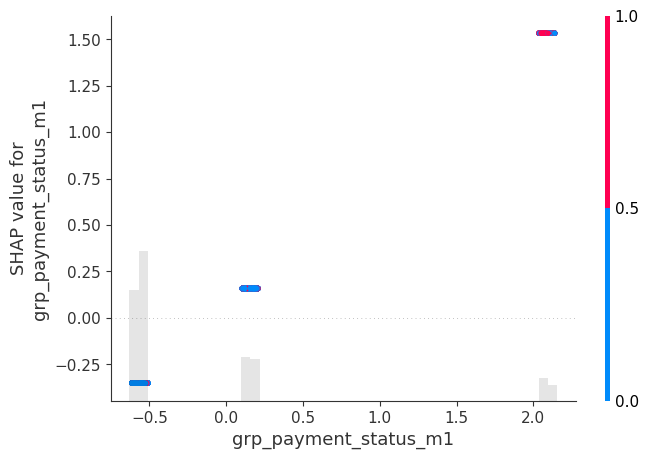

In [40]:

shap.plots.scatter(shap_values_lr[:, 'grp_payment_status_m1'],color =y_test_xgb.to_numpy())

c:\Users\GesaMurphy\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\plots\_scatter.py:452: RuntimeWarning: invalid value encountered in greater
  min_dist = np.min(diffs[diffs > 1e-8])


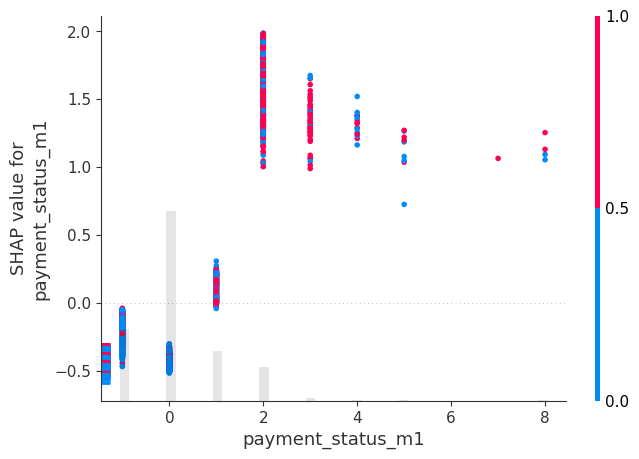

In [41]:
# Zum Vergleich noch einmal XGBoost
shap.plots.scatter(shap_values_xgb[:, 'payment_status_m1'],color =y_test_xgb.to_numpy())


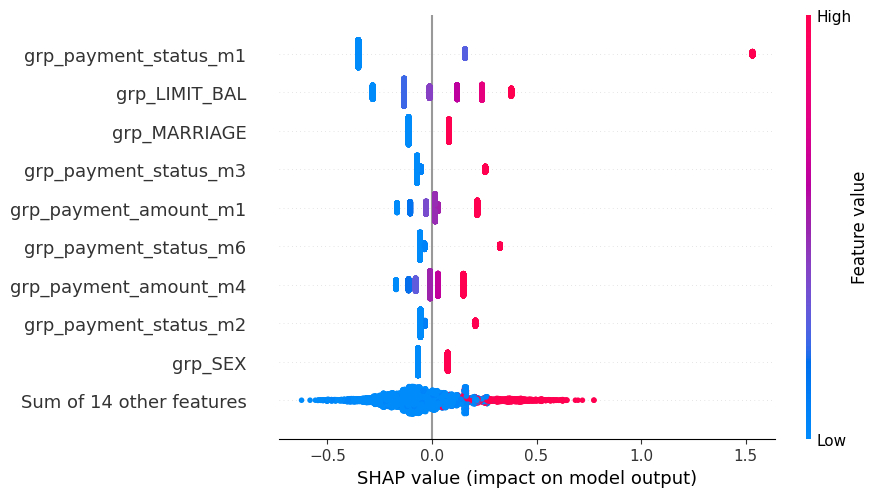

In [42]:
shap.plots.beeswarm(shap_values_lr)

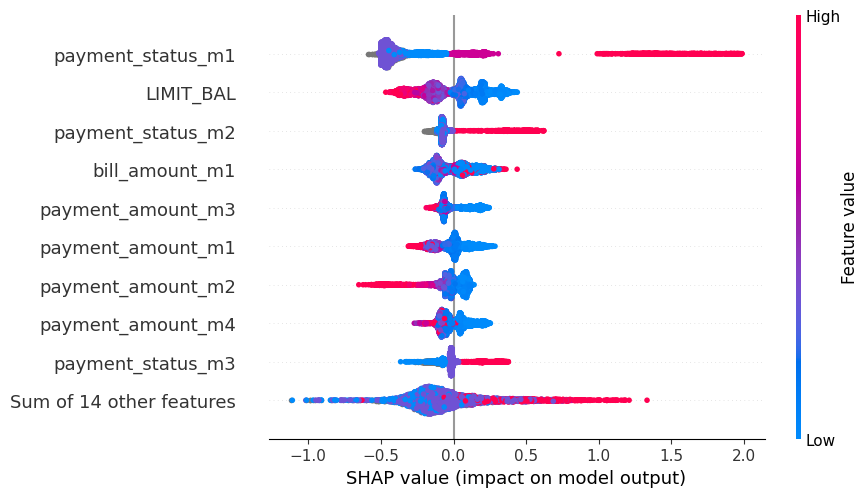

In [43]:
# Zum Vergleich noch einmal XGBoost
shap.plots.beeswarm(shap_values_xgb)